# EP03 - Visão e processamento de imagens

Integrantes: 

- Bruna Lobato - 10666972
- Felipe Noronha - 10737032
- Izabela Fonsceca - 11583721

---

Você pode conferir as entregas anteriores e todas as imagens que constituem a base de dados no [GitHub do projeto](https://github.com/fcnoronha/visao-e-prcessamento-de-imagens).

## 0. Introdução

Esse Jupyter Notebook representa o exercicio programa 3, que consiste em realizar a **segmentação das imagens dos objetos** e **classificação dos objetos utilizando aprendizado de maquina**.

In [1]:
import os
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from skimage import io
from skimage.feature import canny
from skimage.metrics import adapted_rand_error
from skimage.util import img_as_ubyte, img_as_float, img_as_int
from skimage.morphology import remove_small_objects

from scipy import ndimage as ndi

# caminhos para os datasets
RAW_PATH = 'datasets/raw/'
GREY_PATH = 'datasets/original-gray/'
NORM_PATH = 'datasets/normalized/'
AUG_PATH = 'datasets/augmented/'
MANUAL_SEGMENTED_PATH = 'datasets/segmented/manual/'
AUTOM_SEGMENTED_PATH = 'datasets/segmented/automated/'

# 1. Segmentação

A segmentação consiste em demarcar o objeto de interesse na imagem. Em particular, criamos uma imagem binaria onde os pixels com valor 1 cobrem o objeto e os com valor 0 cobrem o fundo. Utilizamos dois metodos para geração das imagens segmentadas: 

- Manual, onde utilizamos um editor de imagens para geração de segmentações que oferecessem um _ground-truth_, e 
- Automática, utilizando funções da biblioteca `skimage` para tornar a classificação de todas as imagens do dataset algo factivel.

## 1.1 Segmentação manual

Para realizar a segmentação manual, selecionamos 175 imagens aleatorias da nossa base de dados original, o que representa 15% das imagens. Em seguida, usamos o software de edição de imagens GIMP para criar as segmentações. 

Uma pequena amostra das imagens segmentadas é apresentada a seguir.

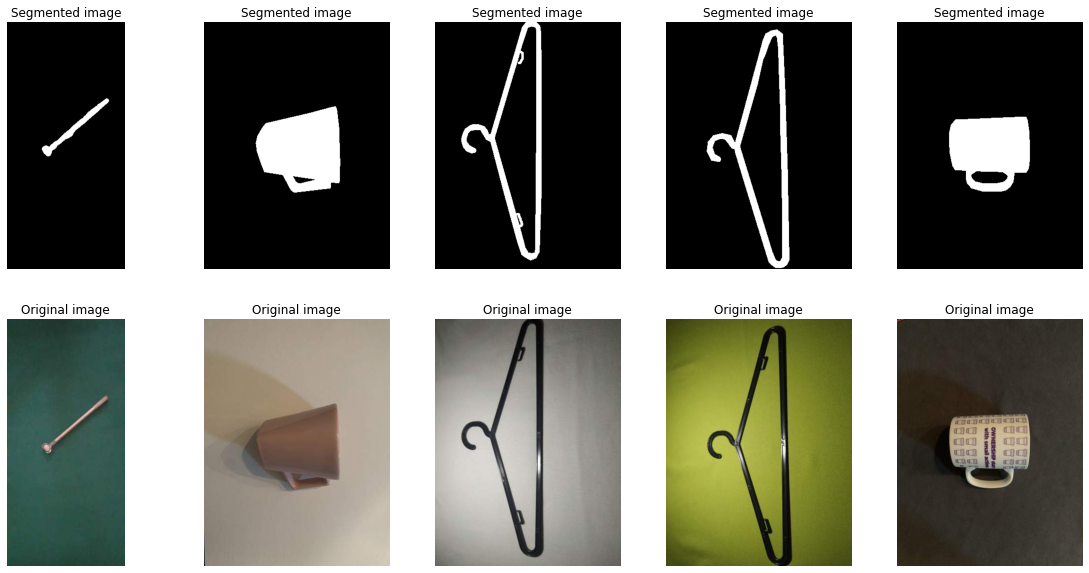

In [2]:
n_samples = 5
image_names = os.listdir(MANUAL_SEGMENTED_PATH)
selection = np.random.choice(image_names, n_samples)

fig, ax = plt.subplots(2, n_samples, figsize = (20, 10))
for i, img_name in zip(range(6), selection):
    
    segmented_image = io.imread(MANUAL_SEGMENTED_PATH + img_name)
    ax[0, i%n_samples].imshow(segmented_image, cmap='gray')
    ax[0, i%n_samples].axis('off')
    ax[0, i%n_samples].set_title('Segmented image')

    original_image = io.imread(RAW_PATH + img_name[:-3] + 'jpg')
    ax[1, i%n_samples].imshow(original_image, cmap='gray')
    ax[1, i%n_samples].axis('off')
    ax[1, i%n_samples].set_title('Original image')

plt.show()

## Segmentação automatica

Para lidar com as mais de mil imagens originais, vamos utilizar metodos da biblioteca `skimage` para realizarmos a segmentação automatica utilizando o detector de bordas de Canny, assim como metodos para preencher o espaço entre as bordas e eliminar pequenos artefatos da segmentação.

Para encontrar os melhores parametros, fizemos uma busca com a intenção de minimizar o [`adapted_rand_error`](https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.adapted_rand_error) que compara a imagem _ground truth_ com a segmentação. Usamos esses parametros para segmentar todas as imagens.

Mais informações sobre as tecnicas aqui usadas podem ser encontradas [neste tutorial](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_metrics.html).

In [1]:
def segment_image(image, sigma, low_t, high_t, min_size):
    
    edges = canny(image, sigma=sigma, low_threshold=low_t/10, high_threshold=high_t/10)
    filled = ndi.binary_fill_holes(edges)
    segmentation = ndi.label(remove_small_objects(filled, min_size))[0]
    return segmentation

def calculate_error_from_parameters(sigma, low_t, high_t, min_size):
    
    error_list = []
    for file in os.listdir(MANUAL_SEGMENTED_PATH):

        if (os.path.isdir(MANUAL_SEGMENTED_PATH + file)): continue

        ground_truth_image = img_as_int(io.imread(MANUAL_SEGMENTED_PATH + file, as_gray=True))
        image = io.imread(GREY_PATH + file[:-3] + 'jpg')
        segmentation = segment_image(image, sigma, low_t, high_t)

        error, precision, recall = adapted_rand_error(ground_truth_image, segmentation)
        error_list.append(error)
    
    return np.mean(error_list)

def search_for_best_parameters():

    lowest_error = np.inf
    best_sigma = best_low_t = best_high_t = best_min_size = 0   

    for sigma in range(0, 6):
        for low_t in range(0, 11):
            for high_t in range(low_t, 11):
                for min_size in range(0, 101, 10):

                    error = calculate_error_from_parameters(sigma, low_t, high_t, min_size)
                    if (error < lowest_error):
                        lowest_error = error
                        best_sigma, best_low_t, best_high_t, best_min_size = sigma, low_t, high_t, min_size

    return best_sigma, best_low_t, best_high_t, best_min_size

sigma, low_t, high_t, min_size = search_for_best_parameters()
print([sigma, low_t, high_t, min_size])

for file in os.listdir(GREY_PATH):
        
        image_name = file.split('.')[0]
        image = io.imread(GREY_PATH + file)
        segmentation = segment_image(sigma, low_t, high_t, min_size)

        io.imsave(AUTOM_SEGMENTED_PATH + image_name + '.png', img_as_ubyte(segmentation), check_contrast=False)